In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/workspaces/Final_Project_DataScient/data/interim/data_limpia.zip')
df

,MARITAL,RENTHOM1,VETERAN3,EMPLOY1,_AGEG5YR,_INCOMG1,_EDUCAG,_CHLDCNT,_EXTETH3,HHADULT,...,ACEPRISN,ACEDIVRC,ACEHURT1,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,FIREARM5,GUNLOAD,LOADULK2
0,1.0,1.0,2.0,7.0,13.0,9.0,4.0,1.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,1.0,2.0,2.0,13.0,3.0,2.0,1.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,2.0,7.0,8.0,6.0,4.0,1.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,2.0,7.0,14.0,9.0,2.0,1.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,2.0,5.0,5.0,3.0,3.0,1.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,5.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445128,1.0,1.0,1.0,1.0,7.0,5.0,4.0,2.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445129,1.0,3.0,2.0,8.0,10.0,9.0,2.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445130,1.0,2.0,2.0,7.0,11.0,5.0,3.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 82 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   MARITAL   445124 non-null  float64
 1   RENTHOM1  445123 non-null  float64
 2   VETERAN3  440959 non-null  float64
 3   EMPLOY1   438936 non-null  float64
 4   _AGEG5YR  445132 non-null  float64
 5   _INCOMG1  445132 non-null  float64
 6   _EDUCAG   445132 non-null  float64
 7   _CHLDCNT  445131 non-null  float64
 8   _EXTETH3  445132 non-null  float64
 9   HHADULT   349071 non-null  float64
 10  SEXVAR    445132 non-null  float64
 11  PERSDOC3  445130 non-null  float64
 12  MEDCOST1  445128 non-null  float64
 13  _HLTHPLN  445132 non-null  float64
 14  _AIDTST4  398897 non-null  float64
 15  SDHEMPLY  253515 non-null  float64
 16  SDHFOOD1  252829 non-null  float64
 17  SDHUTILS  252279 non-null  float64
 18  SDHBILLS  252522 non-null  float64
 19  SDHTRNSP  251943 non-null  float64
 20  CDSO

In [4]:
df = df.drop(columns=["MARIJAN1","MARJSMOK","HADHYST2", "MARJEAT","FLUSHOT7", 
                      "_RFHLTH","CVDINFR4","MARJVAPE", "MARJDAB",
                     "MARJOTHR","ALCDAY4", "AVEDRNK3", 
                     "DRNK3GE5", "MAXDRNKS", "ASBIALCH",
                     "ASBIDRNK", "ASBIBING", "DRNKANY6", 
                     "PERSDOC3", "EXERANY2", "SMOKE100", "USENOW3",
                     "ACEDEPRS", "ACEDRINK", "ACEDRUGS", "ACEPRISN", "ACEDIVRC", 
                     "ACEHURT1", "ACESWEAR", "ACETOUCH", "ACETTHEM", "ACEHVSEX",
                     "CDSOCIAL","CDDISCUS", "CRGVHRS1", "CRGVLNG1", "CRGVREL4", "_EXTETH3",
                     "CAREGIV1", "FIREARM5", "GUNLOAD", "LOADULK2"
                       ])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   MARITAL   445124 non-null  float64
 1   RENTHOM1  445123 non-null  float64
 2   VETERAN3  440959 non-null  float64
 3   EMPLOY1   438936 non-null  float64
 4   _AGEG5YR  445132 non-null  float64
 5   _INCOMG1  445132 non-null  float64
 6   _EDUCAG   445132 non-null  float64
 7   _CHLDCNT  445131 non-null  float64
 8   HHADULT   349071 non-null  float64
 9   SEXVAR    445132 non-null  float64
 10  MEDCOST1  445128 non-null  float64
 11  _HLTHPLN  445132 non-null  float64
 12  _AIDTST4  398897 non-null  float64
 13  SDHEMPLY  253515 non-null  float64
 14  SDHFOOD1  252829 non-null  float64
 15  SDHUTILS  252279 non-null  float64
 16  SDHBILLS  252522 non-null  float64
 17  SDHTRNSP  251943 non-null  float64
 18  SLEPTIM1  445129 non-null  float64
 19  ECIGNOW2  411553 non-null  float64
 20  HIVR

In [6]:
df.shape

(445132, 40)

In [7]:
#tabaco
# 1: No, 2: Yes >> Cambiar a 1: Yes, 0: No
df.loc[df["_RFSMOK3"] == 1, "_RFSMOK3"] = 0
df.loc[df["_RFSMOK3"] == 2, "_RFSMOK3"] = 1
df._RFSMOK3.value_counts()
# 1: No, 2, 3 o 4: Yes >> Cambiar a 1: Yes, 0: No
df.loc[df["ECIGNOW2"] == 1, "ECIGNOW2"] = 0
df.loc[df["ECIGNOW2"] > 1, "ECIGNOW2"] = 1
df.ECIGNOW2.value_counts()
tobacco_columns = ["_RFSMOK3", "ECIGNOW2"]
# Se imputa 0 a los valores vacios que indican no respuesta a la pregunta asumiendo respuesta negativa
df = df.dropna(subset=tobacco_columns)
df["tobacco_use"] = df[tobacco_columns].sum(axis=1)
df = df.drop(tobacco_columns, axis=1)
df["tobacco_use"].value_counts()

tobacco_use
0.0     286153
1.0      96120
2.0      25831
9.0       2022
10.0      1427
Name: count, dtype: int64

In [8]:
df.shape

(411553, 39)

In [9]:
#Alcohol
# 1: No, 2: Yes >> Cambiar a 1: Yes, 0: No
df.loc[df["_RFBING6"] > 2, "_RFBING6"] = -1
df.loc[df["_RFBING6"] == 1, "_RFBING6"] = 0
df.loc[df["_RFBING6"] == 2, "_RFBING6"] = 1
df._RFBING6.value_counts()

_RFBING6
 0.0    337111
 1.0     56915
-1.0     17527
Name: count, dtype: int64

In [10]:
df.shape

(411553, 39)

In [11]:
df["SDHISOLT"].value_counts()

SDHISOLT
5.0    106160
4.0     70617
3.0     53072
2.0     13178
1.0      8098
7.0      1696
9.0       969
Name: count, dtype: int64

In [12]:
#aislamiento social
# 1, 2 y 3: Aislado, 4 y 5: No aislado >> Cambiar a 1: Aislado, 0: No aislado
df.loc[df["SDHISOLT"] <= 3, "SDHISOLT"] = 1
df.loc[(df["SDHISOLT"] == 4) | (df["SDHISOLT"] == 5), "SDHISOLT"] = 0
df.loc[df["SDHISOLT"] > 5, "SDHISOLT"] = -1
df["SDHISOLT"].value_counts()

SDHISOLT
 0.0    176777
 1.0     74348
-1.0      2665
Name: count, dtype: int64

In [13]:
df["EMTSUPRT"].value_counts()

EMTSUPRT
1.0    118012
2.0     77907
3.0     33813
4.0     10835
5.0      9379
7.0      2820
9.0      1375
Name: count, dtype: int64

In [14]:
df.loc[df["EMTSUPRT"] <= 2, "EMTSUPRT"] = 1
df.loc[(df["EMTSUPRT"] == 3) | (df["EMTSUPRT"] == 4) | (df["EMTSUPRT"] == 5), "EMTSUPRT"] = 0
df.loc[df["EMTSUPRT"] > 5, "EMTSUPRT"] = -1
df["EMTSUPRT"].value_counts()

EMTSUPRT
 1.0    195919
 0.0     54027
-1.0      4195
Name: count, dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411553 entries, 0 to 445131
Data columns (total 39 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MARITAL      411551 non-null  float64
 1   RENTHOM1     411552 non-null  float64
 2   VETERAN3     411553 non-null  float64
 3   EMPLOY1      411552 non-null  float64
 4   _AGEG5YR     411553 non-null  float64
 5   _INCOMG1     411553 non-null  float64
 6   _EDUCAG      411553 non-null  float64
 7   _CHLDCNT     411552 non-null  float64
 8   HHADULT      321768 non-null  float64
 9   SEXVAR       411553 non-null  float64
 10  MEDCOST1     411551 non-null  float64
 11  _HLTHPLN     411553 non-null  float64
 12  _AIDTST4     398894 non-null  float64
 13  SDHEMPLY     253515 non-null  float64
 14  SDHFOOD1     252829 non-null  float64
 15  SDHUTILS     252279 non-null  float64
 16  SDHBILLS     252522 non-null  float64
 17  SDHTRNSP     251943 non-null  float64
 18  SLEPTIM1     411553 non-null 

In [16]:
df = df.dropna(subset=[col for col in df.columns if col != "MARIJAN1"])
df.shape

(115712, 39)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115712 entries, 1211 to 445130
Data columns (total 39 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MARITAL      115712 non-null  float64
 1   RENTHOM1     115712 non-null  float64
 2   VETERAN3     115712 non-null  float64
 3   EMPLOY1      115712 non-null  float64
 4   _AGEG5YR     115712 non-null  float64
 5   _INCOMG1     115712 non-null  float64
 6   _EDUCAG      115712 non-null  float64
 7   _CHLDCNT     115712 non-null  float64
 8   HHADULT      115712 non-null  float64
 9   SEXVAR       115712 non-null  float64
 10  MEDCOST1     115712 non-null  float64
 11  _HLTHPLN     115712 non-null  float64
 12  _AIDTST4     115712 non-null  float64
 13  SDHEMPLY     115712 non-null  float64
 14  SDHFOOD1     115712 non-null  float64
 15  SDHUTILS     115712 non-null  float64
 16  SDHBILLS     115712 non-null  float64
 17  SDHTRNSP     115712 non-null  float64
 18  SLEPTIM1     115712 non-nu

In [18]:
df.isnull().sum()

MARITAL        0
RENTHOM1       0
VETERAN3       0
EMPLOY1        0
_AGEG5YR       0
_INCOMG1       0
_EDUCAG        0
_CHLDCNT       0
HHADULT        0
SEXVAR         0
MEDCOST1       0
_HLTHPLN       0
_AIDTST4       0
SDHEMPLY       0
SDHFOOD1       0
SDHUTILS       0
SDHBILLS       0
SDHTRNSP       0
SLEPTIM1       0
HIVRISK5       0
_TOTINDA       0
_RFBING6       0
CVDSTRK3       0
ADDEPEV3       0
DIABETE4       0
COVIDPOS       0
COLNCNCR       0
_MICHD         0
_ASTHMS1       0
_DRDXAR2       0
_PHYS14D       0
_MENT14D       0
_BMI5CAT       0
DECIDE         0
DIFFALON       0
LSATISFY       0
EMTSUPRT       0
SDHISOLT       0
tobacco_use    0
dtype: int64

In [19]:
df.columns

Index(['MARITAL', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', '_AGEG5YR', '_INCOMG1',
       '_EDUCAG', '_CHLDCNT', 'HHADULT', 'SEXVAR', 'MEDCOST1', '_HLTHPLN',
       '_AIDTST4', 'SDHEMPLY', 'SDHFOOD1', 'SDHUTILS', 'SDHBILLS', 'SDHTRNSP',
       'SLEPTIM1', 'HIVRISK5', '_TOTINDA', '_RFBING6', 'CVDSTRK3', 'ADDEPEV3',
       'DIABETE4', 'COVIDPOS', 'COLNCNCR', '_MICHD', '_ASTHMS1', '_DRDXAR2',
       '_PHYS14D', '_MENT14D', '_BMI5CAT', 'DECIDE', 'DIFFALON', 'LSATISFY',
       'EMTSUPRT', 'SDHISOLT', 'tobacco_use'],
      dtype='object')

In [20]:
df["ADDEPEV3"].value_counts()

ADDEPEV3
2.0    91598
1.0    23696
7.0      353
9.0       65
Name: count, dtype: int64

In [21]:
# Lo llevamos a una variable binaria.
# Eliminamos NAN y los valores 7 y 9 (Don’t know/Refused/Missing)
# Pasamos 2 (no) a 0
df['ADDEPEV3'].dropna()
df = df[~df["ADDEPEV3"].isin([9,7])]
df.loc[df["ADDEPEV3"] == 2, "ADDEPEV3"] = 0
print(df["ADDEPEV3"].value_counts())
print(df.shape)

ADDEPEV3
0.0    91598
1.0    23696
Name: count, dtype: int64
(115294, 39)


In [22]:
df.to_csv("../data/processed/data_prefinal.csv", index=False)

In [30]:
# Examen de colon - Reasignación de valores
df.loc[df["COLNCNCR"] == 1, "COLNCNCR"] = 0
df.loc[df["COLNCNCR"] == 2, "COLNCNCR"] = 1
df.loc[df["COLNCNCR"] > 5, "COLNCNCR"] = -1

# Ver distribución de valores
print(df["COLNCNCR"].value_counts())


COLNCNCR
 1.0    88232
 0.0    24186
-1.0     2876
Name: count, dtype: int64


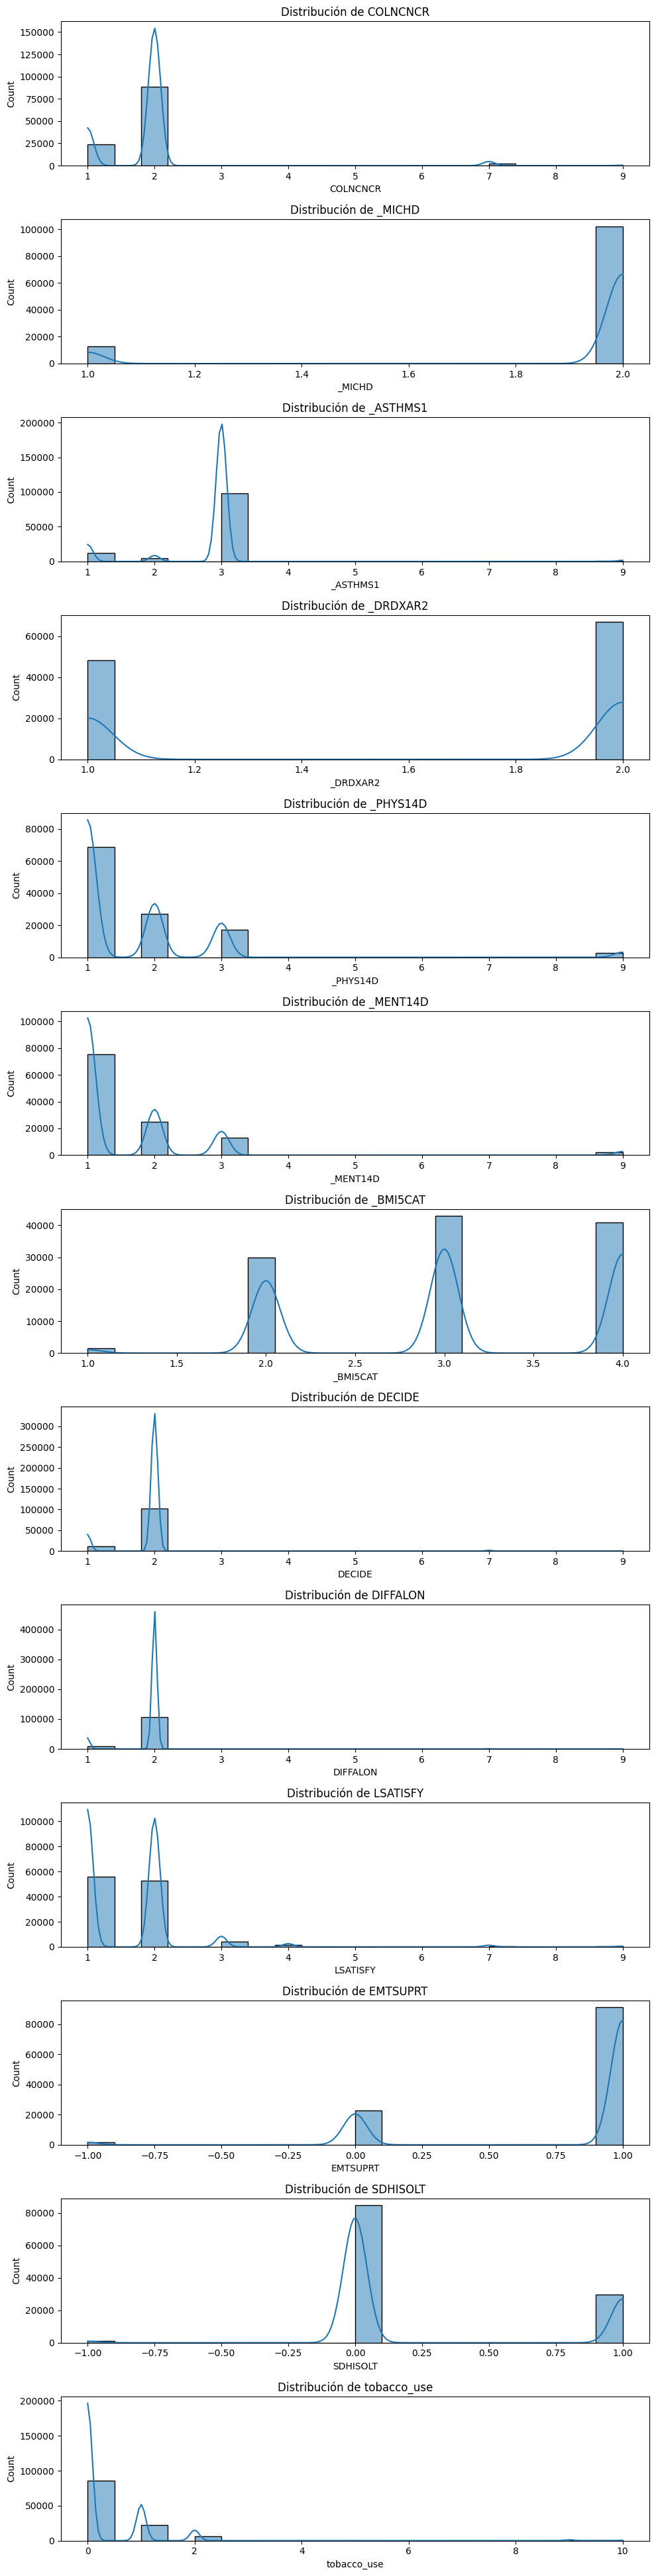

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

variables = ["COLNCNCR", "_MICHD", "_ASTHMS1", "_DRDXAR2", "_PHYS14D", "_MENT14D",
             "_BMI5CAT", "DECIDE", "DIFFALON", "LSATISFY", "EMTSUPRT", "SDHISOLT", "tobacco_use"]

fig, axes = plt.subplots(len(variables), figsize=(10, len(variables) * 3))

for i, var in enumerate(variables):
    sns.histplot(df[var], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    
plt.tight_layout()
plt.show()


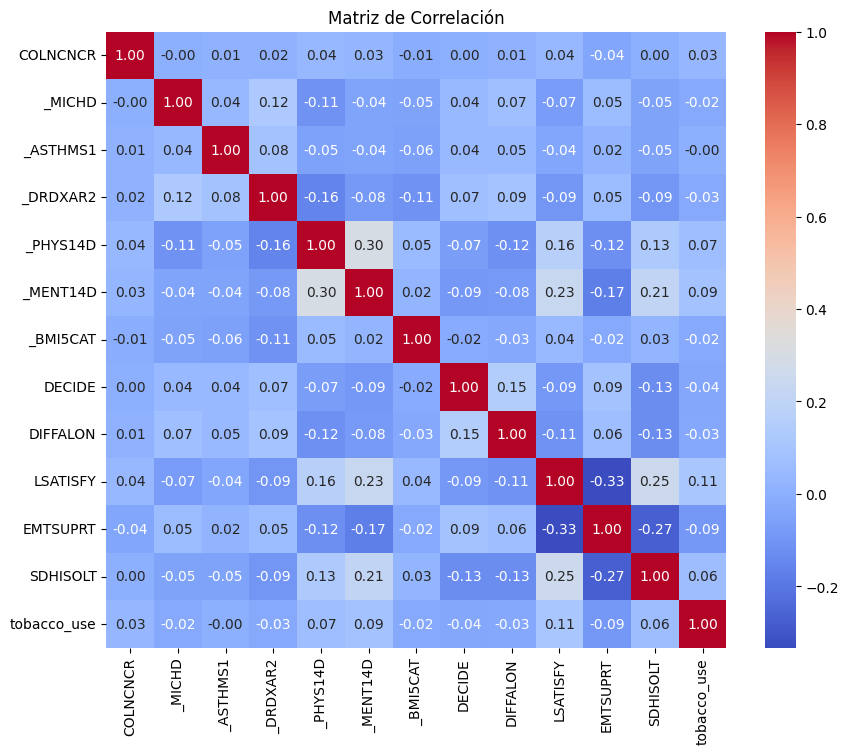

In [25]:
import seaborn as sns

corr_matrix = df[variables].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()
